## Segmentasyon Mimarimiz

In [ ]:
!pip install pydicom opencv-python-headless[app] nibabel matplotlib albumentations tqdm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import os
import glob
import cv2
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from albumentations import HorizontalFlip, VerticalFlip, Rotate
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.image as mpimg
import albumentations as A
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import jaccard_score
from tqdm import tqdm
import nibabel as nib
import albumentations as A
from PIL import Image
from torchvision.transforms import ToTensor, Normalize

height,width = (256,256) 


torch.cuda.is_available()

True

In [2]:
import torch
import numpy as np
from torch.utils.data import Dataset
import nibabel as nib
import albumentations as A
import pydicom
import cv2

def mask_transform(mask, classes):
    new_mask = np.zeros(mask.shape, dtype=np.uint8)
    for i, label in enumerate(classes):
        new_mask[mask == label] = i
    return new_mask

class LoadData(Dataset):
    def __init__(self, images_path, masks_path, classes):
        super().__init__()

        self.images_path = images_path
        self.masks_path = masks_path
        self.classes = classes
        self.len = len(images_path)
        self.transform = A.Compose([
            A.Resize(height=height,width=width,p=1.0),
            A.augmentations.transforms.CLAHE(clip_limit=(2.0,3.0), tile_grid_size=(8, 8), always_apply=False, p=0.5) 
        ])
        self.to_tensor = ToTensor()
        self.normalize = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    def __getitem__(self, idx):
        img = pydicom.dcmread(self.images_path[idx])
        monochrome=img.PhotometricInterpretation
        img=img.pixel_array
        mask = nib.load(self.masks_path[idx])
        mask=mask.get_fdata()
        
        #3 kişinin farklı etiketleri için farklı bir kod yazıldı
        if 'Sinem' in self.images_path[idx] :
            if 'LCC' in self.images_path[idx]:
                mask=mask[:,:,1]
            elif 'LMLO' in self.images_path[idx]:
                mask=mask[:,:,3]
            elif 'RCC' in self.images_path[idx]:
                mask=mask[:,:,0]
            elif 'RMLO' in self.images_path[idx]:
                mask=mask[:,:,2]

        elif 'Ertan' in self.images_path[idx]:
            mask=mask[:,:,0]
            
        elif 'Zeynep' in self.images_path[idx]:
            if 'LCC' in self.images_path[idx]:
                mask=mask[:,:,0]
            elif 'LMLO' in self.images_path[idx]:
                mask=mask[:,:,1]
            elif 'RCC' in self.images_path[idx]:
                mask=mask[:,:,2]
            elif 'RMLO' in self.images_path[idx]:
                mask=mask[:,:,3]

        #maskeler tam oturmadığı için bu işlemler yapıldı
        mask=np.flip(mask)
        mask=np.rot90(mask)
        mask=np.fliplr(mask)

        if monochrome=='MONOCHROME1':
            img=np.invert(img)

        img = ((img - img.min()) * (1/(img.max() - img.min()) * 255)).astype('uint8')
        
        #img, mask = np.array(img), np.array(mask)
        transformed = self.transform(image=img,mask=mask)
        img = transformed['image']
        mask = transformed['mask']
        
        #img = np.array([img,img,img])
        #*****************************
        #maskelerin her biri tek kanalda olacak şekilde ayrı ayrı oluşturuldu
        mask_list=[]
        temp_mask=mask.copy()
        temp_mask[mask==1]=1
        temp_mask[mask==2]=0
        temp_mask[mask==3]=0
        mask_list.append(temp_mask)

        temp_mask=mask.copy()
        temp_mask[mask==1]=0
        temp_mask[mask==2]=1
        temp_mask[mask==3]=0    #*1

        mask_list.append(temp_mask)
        
        temp_mask=mask.copy()
        temp_mask[mask==1]=0
        temp_mask[mask==2]=0
        temp_mask[mask==3]=1    #*0
        mask_list.append(temp_mask)
        
        mask=np.array(mask_list)

        img = np.array([img,img,img])

        #********************************
        img=np.moveaxis(img,0,-1)
        mask=np.moveaxis(mask,0,-1)

        img = self.to_tensor(img)

        mask = self.to_tensor(mask)
        return img, mask

    def __len__(self):
        return self.len


In [28]:
from torch.utils.data import DataLoader, random_split

# Veri kümesini oluşturun
PATH="/home/uraninjo/Desktop/Çalışmalar/Mergen1-Teknofest/data"

tr_images_path =sorted(glob.glob(f'{PATH}/images/[Ertan,Zeynep]*/*/*.dcm'))  # Görüntü yollarının listesi
val_images_path =sorted(glob.glob(f'{PATH}/images/Sinem/*/*.dcm'))  # Görüntü yollarının listesi

tr_masks_path=sorted(glob.glob(f'{PATH}/masks/[Ertan,Zeynep]*/*/*.nii.gz'))
val_masks_path=sorted(glob.glob(f'{PATH}/masks/Sinem/*/*.nii.gz'))  # Maske yollarının listesi
classes = [0, 1, 2]  # Orijinal etiket değerleri
print(len(tr_images_path))
print(len(tr_masks_path))

560
560


In [29]:
tr_dataset = LoadData(tr_images_path, tr_masks_path, classes)
val_dataset = LoadData(val_images_path, val_masks_path, classes)

# # Veri kümesini eğitim ve doğrulama alt kümelerine ayırma
# train_size = int(0.8 * len(dataset))
# val_size = len(dataset) - train_size
# train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoader oluşturma
train_loader = DataLoader(tr_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

torch.Size([3, 256, 256])

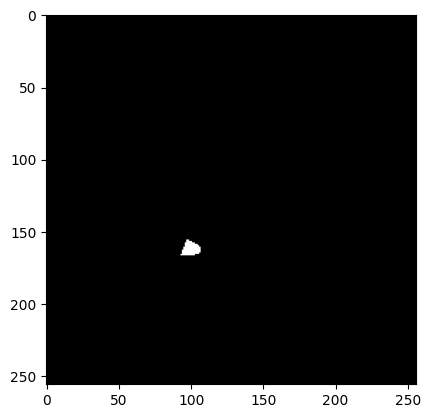

In [30]:
imgs,masks=tr_dataset[341]


# img=np.invert(imgs)
#plt.imshow(imgs,cmap="gray")

# plt.imshow(np.transpose(imgs,(1,2,0)),cmap="inferno")

plt.imshow(np.transpose(masks,(1,2,0))[:,:,2],cmap="gray")
plt.imshow
masks.shape

In [31]:
np.transpose(masks,(1,2,0))[:,:,2]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)

In [32]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)
    
    
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_out = self.down_sample(skip_out)
        return (down_out, skip_out)

    
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, up_sample_mode):
        super(UpBlock, self).__init__()
        if up_sample_mode == 'conv_transpose':
            self.up_sample = nn.ConvTranspose2d(in_channels-out_channels, in_channels-out_channels, kernel_size=2, stride=2)        
        elif up_sample_mode == 'bilinear':
            self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            raise ValueError("Unsupported `up_sample_mode` (can take one of `conv_transpose` or `bilinear`)")
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        return self.double_conv(x)

    
class UNet(nn.Module):
    def __init__(self, out_classes=3, up_sample_mode='conv_transpose'):
        super(UNet, self).__init__()
        self.up_sample_mode = up_sample_mode
        # Downsampling Path
        self.down_conv1 = DownBlock(3, 64)
        self.down_conv2 = DownBlock(64, 128)
        self.down_conv3 = DownBlock(128, 256)
        self.down_conv4 = DownBlock(256, 512)
        # Bottleneck
        self.double_conv = DoubleConv(512, 1024)
        # Upsampling Path
        self.up_conv4 = UpBlock(512 + 1024, 512, self.up_sample_mode)
        self.up_conv3 = UpBlock(256 + 512, 256, self.up_sample_mode)
        self.up_conv2 = UpBlock(128 + 256, 128, self.up_sample_mode)
        self.up_conv1 = UpBlock(128 + 64, 64, self.up_sample_mode)
        # Final Convolution
        self.conv_last = nn.Conv2d(64, out_classes, kernel_size=1)
        
        

    def forward(self, x):
        x, skip1_out = self.down_conv1(x)
        x, skip2_out = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        x, skip4_out = self.down_conv4(x)
        x = self.double_conv(x)
        x = self.up_conv4(x, skip4_out)
        x = self.up_conv3(x, skip3_out)
        x = self.up_conv2(x, skip2_out)
        x = self.up_conv1(x, skip1_out)
        x = self.conv_last(x)
        
        return x
    

# Get UNet model
model = UNet()

In [35]:
from sklearn.metrics import jaccard_score

def calculate_dice(y_true, y_pred):
    y_true = y_true.cpu().numpy()
    y_pred = y_pred
    intersection = np.sum(y_true * y_pred)
    return (2 * intersection) / (np.sum(y_true) + np.sum(y_pred))

def dice_loss(pred, target, epsilon=1e-7, use_sigmoid=True):
    pred = pred.contiguous()
    if use_sigmoid:
        pred = torch.sigmoid(pred)
    target = target.contiguous()
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    loss = (1 - ((2. * intersection + epsilon) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + epsilon)))
    return loss.mean()

def calculate_jaccard(y_true, y_pred):
    # print(y_true.shape)
    y_true = y_true.cpu().numpy()
    y_pred = y_pred
    return jaccard_score(y_true, y_pred, average="macro")



import matplotlib.pyplot as plt
def visualize_image_mask(image, mask, pred_mask):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(image.permute(1, 2, 0).cpu().numpy())
    ax[0].set_title("Image")
    ax[1].imshow(mask.squeeze(0).permute(1, 2, 0).cpu().numpy(), cmap="gray")
    ax[1].set_title("True Mask")
    ax[2].imshow(np.dstack((pred_mask[0], pred_mask[1], pred_mask[2])), cmap="gray")
    ax[2].set_title("Predicted Mask")
    print(pred_mask.shape)
    print(np.unique(pred_mask[0,:,:]))
    print(np.unique(mask.cpu().numpy()))

    plt.show()

def visualize_image_mask(image, mask, pred_mask):
    fig, ax = plt.subplots(1, 6, figsize=(15, 5))
    ax[0].imshow(image.permute(1, 2, 0).cpu().numpy())
    ax[0].set_title("Image")
    ax[1].imshow(mask.squeeze(0).permute(1, 2, 0).cpu().numpy(), cmap="gray")
    ax[1].set_title("True Mask")
    pred_mask1=np.array([pred_mask[0],pred_mask[0],pred_mask[0]])
    pred_mask2=np.array([pred_mask[1],pred_mask[1],pred_mask[1]])
    pred_mask3=np.array([pred_mask[2],pred_mask[2],pred_mask[2]])
    ax[2].imshow(np.transpose(pred_mask1,(1,2,0)), cmap="gray")
    ax[2].set_title("Pektoral Predicted Mask")
    ax[3].imshow(np.transpose(pred_mask2,(1,2,0)), cmap="gray")
    ax[3].set_title("Meme Predicted Mask")
    ax[4].imshow(np.transpose(pred_mask3,(1,2,0)), cmap="gray")
    ax[4].set_title("Meme Ucu Predicted Mask")
    ax[5].imshow(np.transpose(pred_mask,(1,2,0)), cmap="gray")
    ax[5].set_title("All Predicted Mask")

    # print(pred_mask.shape)
    # print(np.unique(pred_mask[0,:,:]))
    # print(np.unique(mask.cpu().numpy()))
    plt.show()


def validate_unet(model, val_loader, device, criterion):
    model.eval()
    val_loss = 0.0
    jaccard = 0.0
    dice = 0.0

    with torch.no_grad():
        for i, (inputs, masks) in enumerate(val_loader):
            inputs, masks = inputs.cpu().to(device), masks.cpu().to(device)
            outputs = model(inputs)
            loss = criterion(outputs, masks)

            val_loss += loss.item()
            # print(outputs.shape)
            
            output_np=outputs.detach().cpu()
            output_np=np.array(output_np)
            output_np=output_np-np.min(output_np)
            output_np=output_np/np.max(output_np)
            predicted_masks=np.around(output_np, decimals=0, out=None)
            # _, predicted_masks = torch.max(outputs, 1)
            # jaccard += calculate_jaccard(masks[0], predicted_masks[0])
            dice += calculate_dice(masks[0], predicted_masks[0])

            # İlk örnek için görselleştirme
            
            if i == 1:
                visualize_image_mask(inputs[0], masks[0], predicted_masks[0])
            if i == 2:
                visualize_image_mask(inputs[0], masks[0], predicted_masks[0])
            # if i == 3:
            #     visualize_image_mask(inputs[0], masks[0], predicted_masks[0])
            # if i == 4:
            #     visualize_image_mask(inputs[0], masks[0], predicted_masks[0])

    val_loss /= len(val_loader)
    jaccard /= len(val_loader)
    dice /= len(val_loader)
    return val_loss, jaccard, dice

def train_unet(epochs, device):
    try:
        os.mkdir("./checkpoints")
    except:
        print("Checkpoints directory already exists")

    model = UNet()
    model=model.to(device)
    model.load_state_dict(torch.load("/home/uraninjo/Desktop/Çalışmalar/Mergen1-Teknofest/Murat/checkpoints3/Murat3Kanal_8_ValLoss0.4248_diceScore0.9020.pt"))
    criterion = dice_loss
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    best_loss = float('inf')
    train_losses = []

    best_dice = float('inf')*(-1)

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        # Eğitim
        model.train()
        train_loss = 0.0
        
        for inputs, masks in tqdm(train_loader, desc="Training"):
            inputs, masks = inputs.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            
            loss = criterion(outputs, masks)
            
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        print(f"Train Loss: {train_loss:.4f}")

        # Doğrulama
        val_loss, jaccard, dice = validate_unet(model, val_loader, device, criterion)
        print(f"Val Loss: {val_loss:.4f}, Dice Score: {dice:.4f}")

        # En iyi modeli kaydetme
        if dice > best_dice:
            best_dice = dice
            torch.save(model.state_dict(), f"./checkpoints/{epoch}_ValLoss{val_loss:.4f}_diceScore{dice:.4f}.pt")

    return train_losses


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_model = train_unet(epochs=30, device=device)

In [ ]:
#Test
def visualize_test_mask(output_np,masks):
    fig, axs = plt.subplots(1, 2)
    print(output_np.shape)
    axs[0].imshow(np.transpose(output_np[0],(1,2,0)),cmap="gray")
    axs[0].set_title("Predicted mask")
    axs[1].imshow(np.transpose(masks.cpu()[0],(1,2,0)))
    axs[1].set_title("Ground truth mask")
    plt.show()


def test_unet(model, test_loader, device, criterion):
    model.eval()
    test_loss = 0.0
    jaccard = 0.0
    dice = 0.0

    with torch.no_grad():
        for i, (inputs, masks) in enumerate(test_loader):
            inputs, masks = inputs.to(device), masks.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, masks)

            test_loss += loss.item()

            output_np = outputs.detach().cpu().numpy()
            output_np = output_np - np.min(output_np)
            output_np = output_np / np.max(output_np)
            predicted_masks = np.around(output_np, decimals=0, out=None)
            
            
            visualize_image_mask(inputs[0], masks[0], predicted_masks[0])


            dice += calculate_dice(masks[0], predicted_masks[0])

    test_loss /= len(test_loader)
    jaccard /= len(test_loader)
    dice /= len(test_loader)
    return test_loss, jaccard, dice

def run_unet_test(model_path, test_dataset, device):
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    model = UNet()
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    criterion = dice_loss

    test_loss, jaccard, dice = test_unet(model, test_loader, device, criterion)

    print(f"Test Loss: {test_loss:.4f}, Dice Score: {dice:.4f}")

run_unet_test(f"/home/uraninjo/Desktop/Çalışmalar/Mergen1-Teknofest/Murat/checkpoints3/Murat3Kanal_8_ValLoss0.4248_diceScore0.9020.pt",val_dataset,device="cuda")